# Calculating the Brightness of a Line
Now that we are able to fit a Gaussian to the line, we can calculate its brightness after using the MCMC process to get the parameters we need.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy.table import Table
import emcee
from IPython.display import display, Math
#%matplotlib inline
%config InlineBackend.figure_format='retina'

In [39]:
line = 1250.814 #give which line initially before any code is run
def generative_model(A, mu, logw, int_wl = line):
    """Generate the model given parameters"""
    w = np.exp(logw)
    gaussian = A * np.exp(-0.5*(wl-mu)**2/w**2)
    return gaussian

In [40]:
def log_likelihood(theta):
    A, mu, logw = theta
    model = generative_model(A, mu, logw, int_wl = line)
    residual = flux - model
    chi_squared = np.sum(residual** 2 / unc**2)
    return -0.5 * chi_squared

In [41]:
hdulist = fits.open('../data/composite_Io_eclipsed.fits')
evt_data = Table(hdulist[1].data)
image_data = hdulist[1].data
df = pd.read_csv('../data/Io_Master_Line_List (1).csv') #spaces in csv file will make df object type and not float64
line = "S I"
target_mask = df.Species.str.endswith(line) #probably a better function but idk it right now
df = df[target_mask]
df_wavelength = df['Wavelength']
df_species = df['Species']

(-5e-16, 1.5e-14)

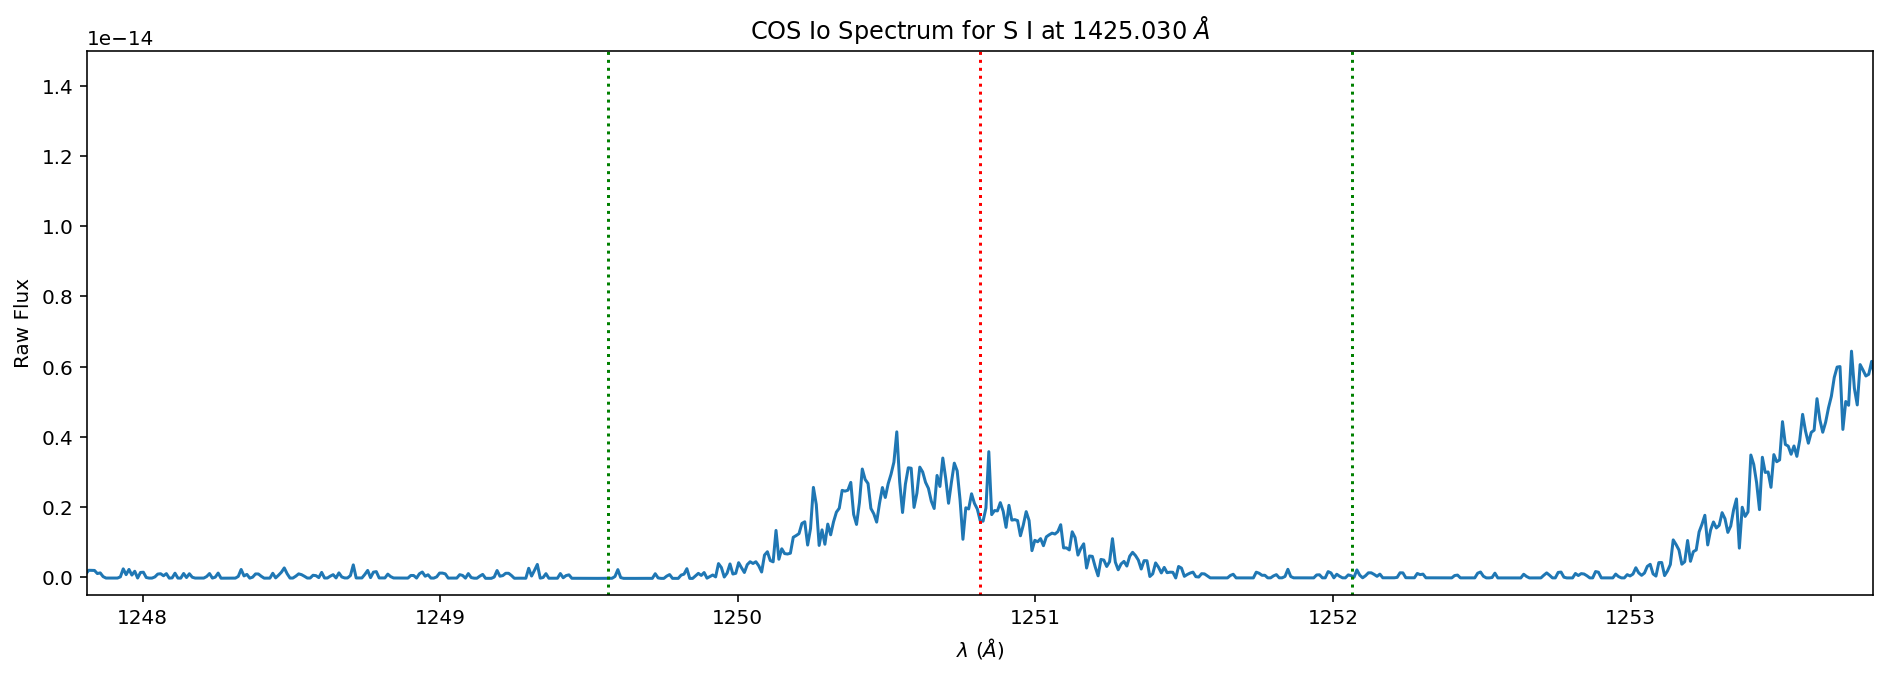

In [42]:
line = 1250.814
left_bound = 0.999*line
right_bound = 1.001*line
plt.figure(figsize=(16, 5))
plt.plot(evt_data['WAVELENGTH'].T, evt_data['FLUX'].T) #make it columns instead of rows bc otherwise will be a blank plot
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.title("COS Io Spectrum for S I at 1425.030 $\AA$")
plt.axvline(line, color = 'red', linestyle = 'dotted')
plt.axvline(left_bound, color = 'green', linestyle = 'dotted')
plt.axvline(right_bound, color = 'green', linestyle = 'dotted')
plt.xlim(line-3,line+3)
plt.ylim(-0.005*10**-13,0.15*10**-13)

In [43]:
sub_region = (evt_data['WAVELENGTH'] > left_bound) & (evt_data['WAVELENGTH'] < right_bound) #only take values within this area
wl = evt_data['WAVELENGTH'][sub_region]
flux = evt_data['FLUX'][sub_region]

In [44]:
A_guess, mu_guess, logw_guess = 0.04*10**-13, line, np.log(0.2)
flux_guess = generative_model(A_guess, mu_guess, logw_guess)

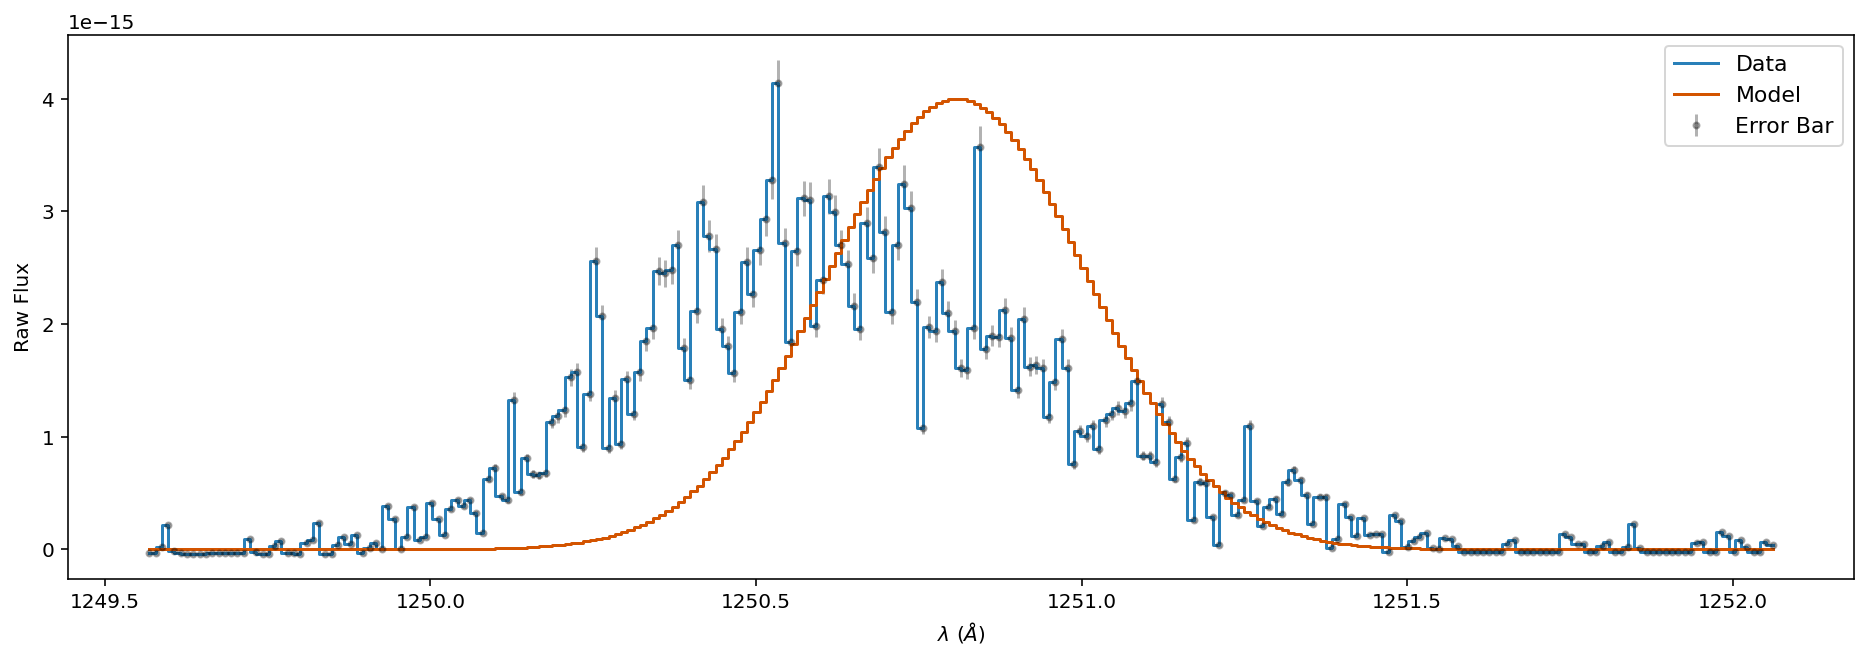

In [45]:
unc = 0.05*flux #placeholder uncertainty
plt.figure(figsize=(16, 5))
plt.step(wl, flux, label='Data', color='#2980b9');
plt.step(wl, flux_guess, label='Model', color='#d35400');
plt.errorbar(wl, flux, unc, fmt='.', c='k',label="Error Bar", alpha=0.3);
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.legend(fontsize=11);

In [46]:
theta_guess = np.array([A_guess, mu_guess, logw_guess])
log_likelihood(theta_guess) #more magnitude the log_likelihood, the worse the fit

-92597.62111325334

In [47]:
n_walkers = 32
n_params = 3
n_steps = 5000
pos = theta_guess + 1e-4 * np.random.randn(n_walkers, n_params)

In [48]:
sampler = emcee.EnsembleSampler(n_walkers, n_params, log_likelihood)
sampler.run_mcmc(pos, n_steps, progress=True);

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:03<00:00, 78.19it/s]


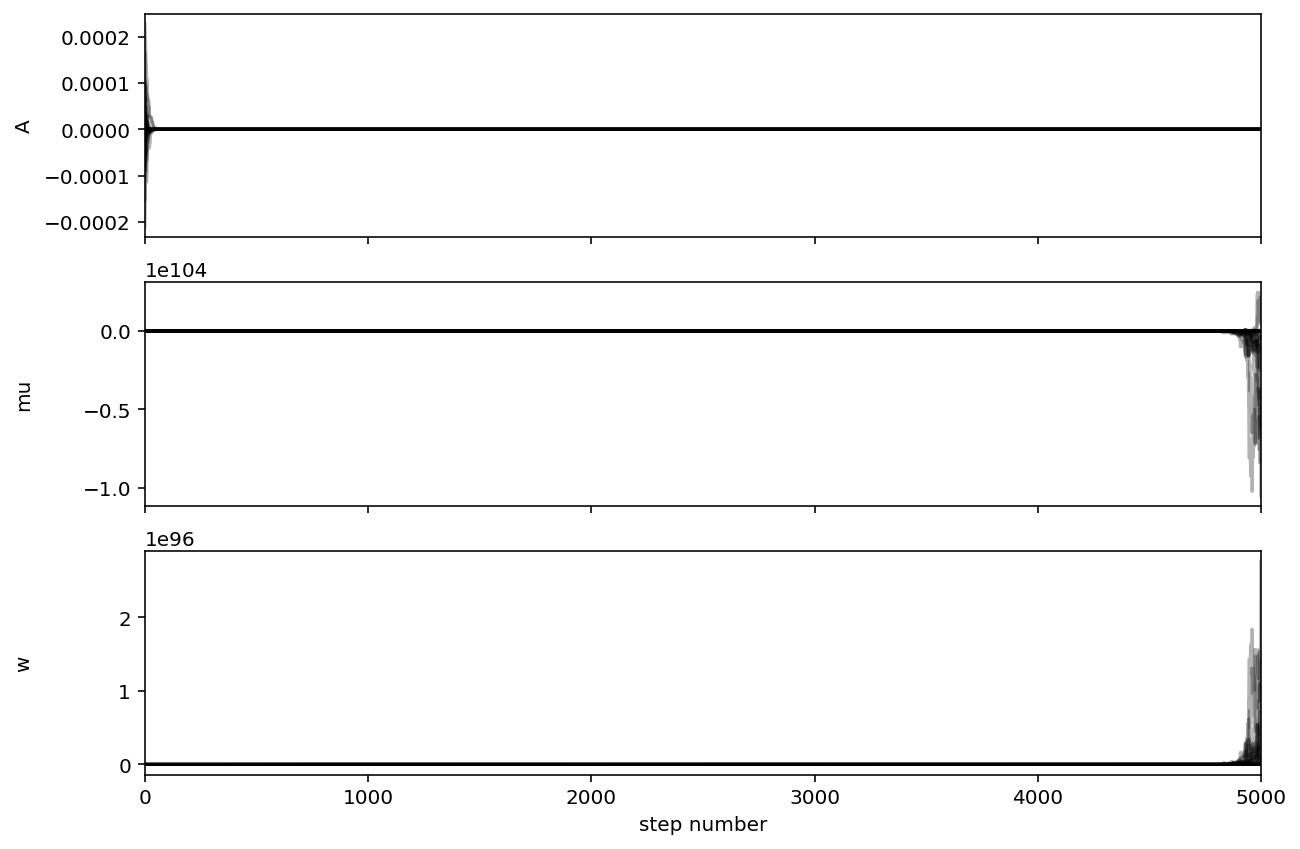

In [30]:
fig, axes = plt.subplots(n_params, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["A", "mu", "w"]
for i in range(n_params):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [31]:
flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)
print(flat_samples.shape)

(8512, 3)


In [32]:
ndim = 3
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [33]:
A_draws = samples[2000:, :, 0].reshape(-1)
mu_draws = samples[2000:, :, 1].reshape(-1)
w_draws = np.exp(samples[2000:, :, 2].reshape(-1))

C:\Users\jojoa\.conda\envs\io_env\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


In [34]:
A_fit, mu_fit, w_fit = flat_samples[3912, :]
good_fit = generative_model(A_fit, mu_fit, w_fit, int_wl = line)

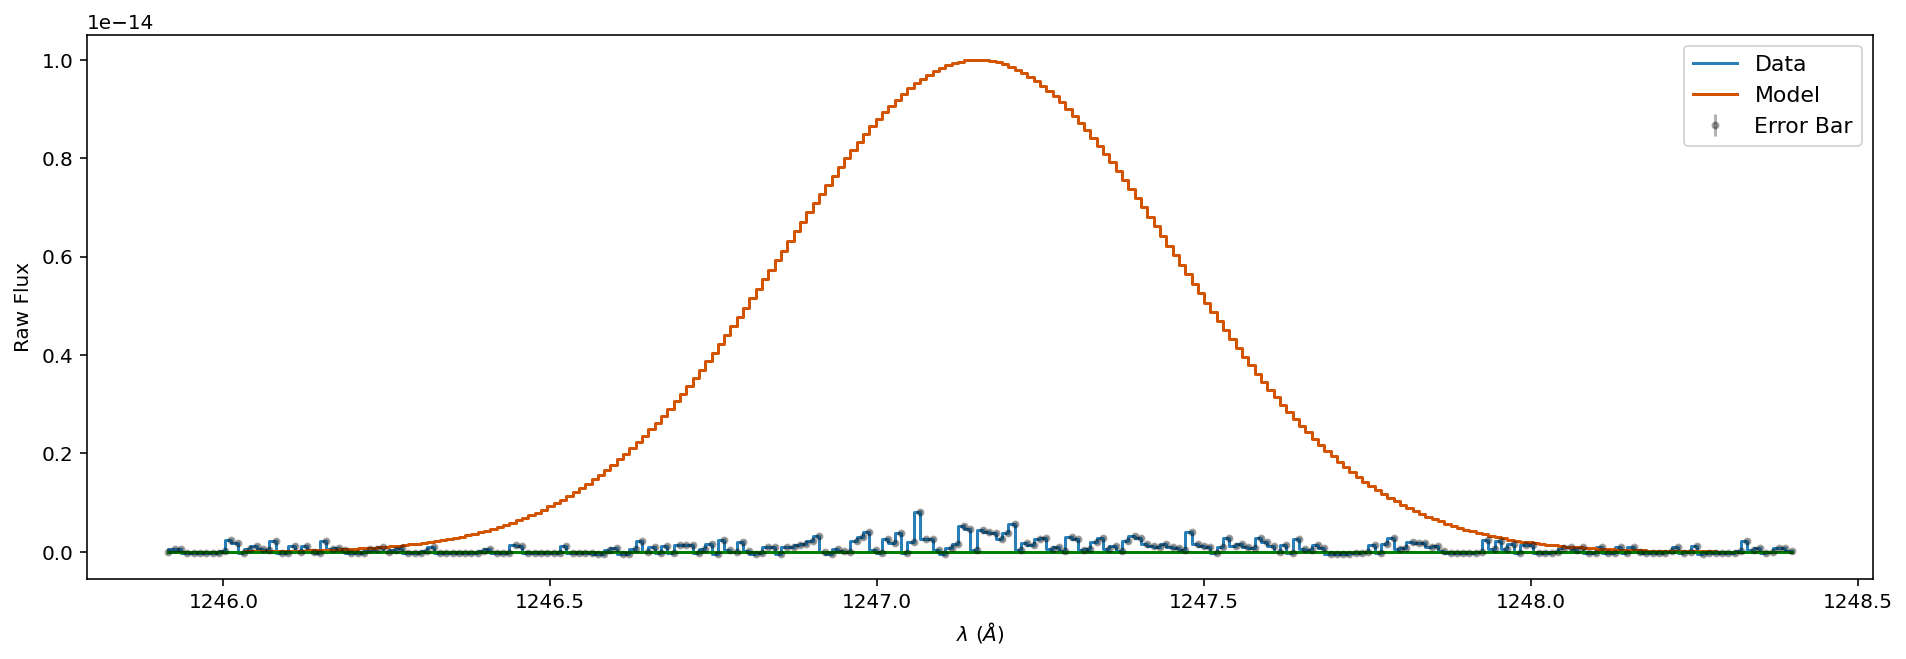

In [35]:
plt.figure(figsize=(16, 5))
plt.step(wl, flux, label='Data', color='#2980b9');
plt.step(wl, flux_guess, label='Model', color='#d35400');
plt.errorbar(wl, flux, unc, fmt='.', c='k',label="Error Bar", alpha=0.3);
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.legend(fontsize=11);
plt.step(wl, good_fit, label='MCMC', color='green');

Now, let's calculate the brightness of this S I line!

In [36]:
brightness = -((2*np.pi)**.5)*(A_draws*w_draws)
brightness

array([           inf, 1.27738334e-15, 1.51069654e-15, ...,
       2.19495742e-14,            inf, 2.87554896e-16])

1.2779144064000441e-13
2.939949571756924e-13


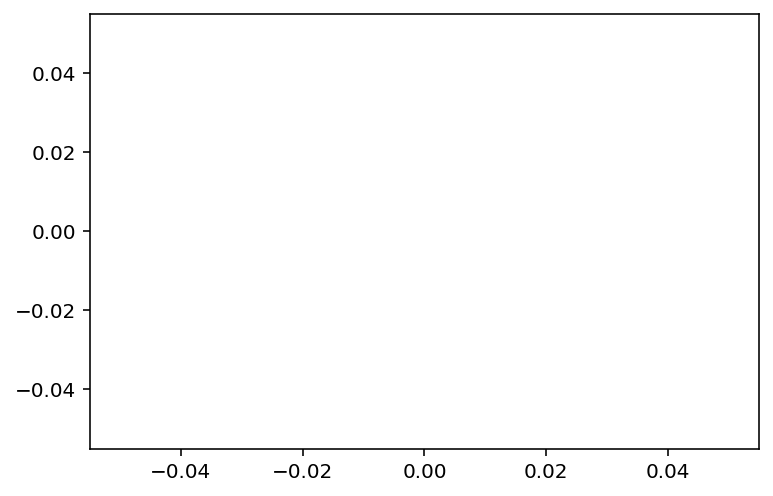

In [19]:
brightness_mean = np.mean(brightness)
brightness_std = np.std(brightness)
plt.hist(brightness, bins = np.arange(brightness_mean*0.999, brightness_mean*1.001, brightness_mean*.01));
print(brightness_mean)
print(brightness_std)